<a href="https://colab.research.google.com/github/akirakudo901/Joystick-Prediction/blob/feature_extraction/Index.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ECoG Dataset

## Downloading the Dataset

In [1]:
from matplotlib import rcParams
from matplotlib import pyplot as plt
import os, requests
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
import numpy as np
from scipy import signal, fft
import matplotlib.animation as animation
import math

In [2]:
fname = 'joystick_track.npz'
url = "https://osf.io/6jncm/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [3]:
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

## Dataset info


This is one of multiple ECoG datasets from Miller 2019, recorded in clinical settings with a variety of tasks. Raw data here:

https://exhibits.stanford.edu/data/catalog/zk881ps0522

`dat` contain 4 sessions from 4 subjects, and was used in these papers:

- Schalk, G., et al. "Decoding two-dimensional movement trajectories using electrocorticographic signals in humans." Journal of Neural Engineering 4.3 (2007): 264. doi: [10.1088/1741-2560/4/3/012](https://doi.org/10.1088/1741-2560/4/3/012)

- Schalk, Gerwin, et al. "Two-dimensional movement control using electrocorticographic signals in humans." Journal of Neural Engineering 5.1 (2008): 75. doi: [10.1088/1741-2560/5/1/008](https://doi.org/10.1088/1741-2560/5/1/008)

<br>

From the dataset readme:

*During the study, each patient was in a semi-recumbent position in a hospital bed about 1 m from a computer monitor. The patient used a joystick to maneuver a white cursor track a green target moving counter-clockwise in a circle of diameter 85% of monitor height ~1m away. The hand used to control the joystick was contralateral to the implanted electrode array.*

<br>

We also know that subject 0 was implanted in the left temporal lobe, while subject 2 was implanted in the right frontal lobe.

Sample rate is always 1000Hz, and the ECoG data has been notch-filtered at 60, 120, 180, 240 and 250Hz, followed by z-scoring across the entire recording and conversion to float16 to minimize size.

Variables are:
* `dat['V']`: continuous voltage data (time by channels)
* `dat['targetX']`: position of the target on the screen
* `dat['targetY']`: position of the target on the screen
* `dat['cursorX']`: X position of the cursor controlled by the joystick
* `dat['cursorY']`: X position of the cursor controlled by the joystick
* `dat['locs`]: three-dimensional coordinates of the electrodes

### Data Loading

In [4]:
# DEFINING USEFUL CONSTANTS
SAMPLE_RATE = 1000
# By checking cursor sample rate in "Identifying sample ..." below, we figured
# the sample rate of cursor on screen was identified every 40 time points
TIMEPOINTS_PER_CURSOR_UPDATE = 40

Shape of alldat: (1, 4)
dict_keys(['V', 'targetX', 'targetY', 'cursorX', 'cursorY', 'locs', 'hemisphere', 'lobe', 'gyrus', 'Brodmann_Area'])
Shape of V: (372760, 60)
Shape of targetX: (372760, 1)
Shape of targetY: (372760, 1)
Shape of cursorX: (372760, 1)
Shape of cursorY: (372760, 1)


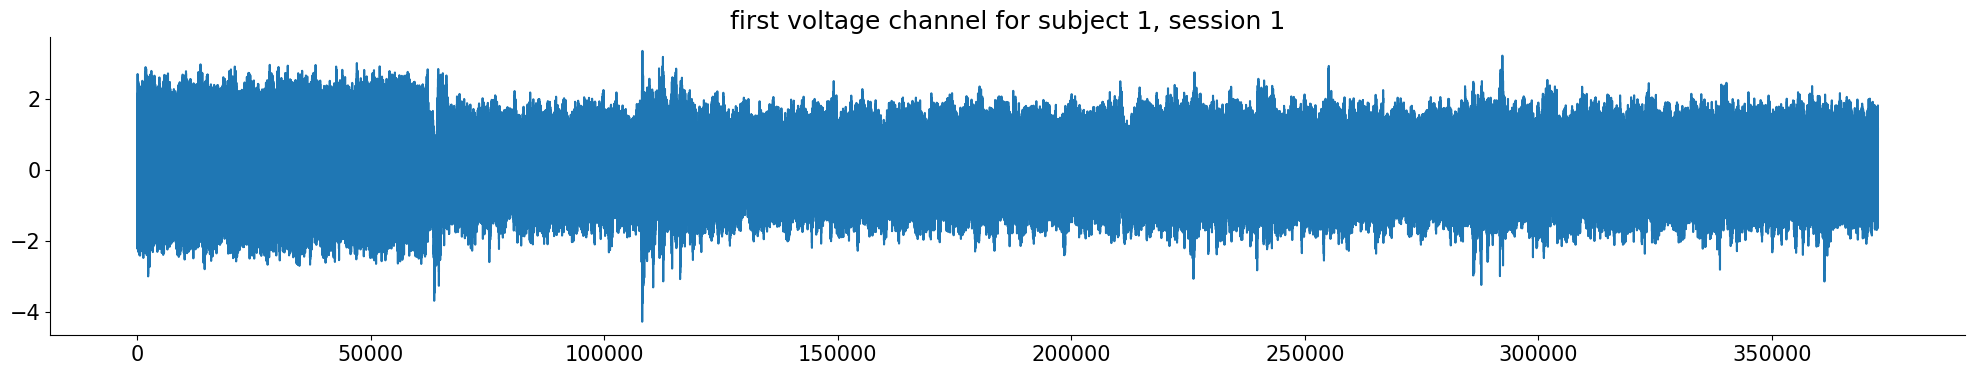

In [5]:
alldat = np.load(fname, allow_pickle=True)['dat']
print("Shape of alldat:", alldat.shape)

# Select just one of the recordings here. This is subject 1, block 1.
dat = alldat[0][0]
print(dat.keys())
print("Shape of V:", dat['V'].shape)
print("Shape of targetX:", dat['targetX'].shape)
print("Shape of targetY:", dat['targetY'].shape)
print("Shape of cursorX:", dat['cursorX'].shape)
print("Shape of cursorY:", dat['cursorY'].shape)

plt.plot(dat['V'][:, 0])
plt.title("first voltage channel for subject 1, session 1")
plt.show()

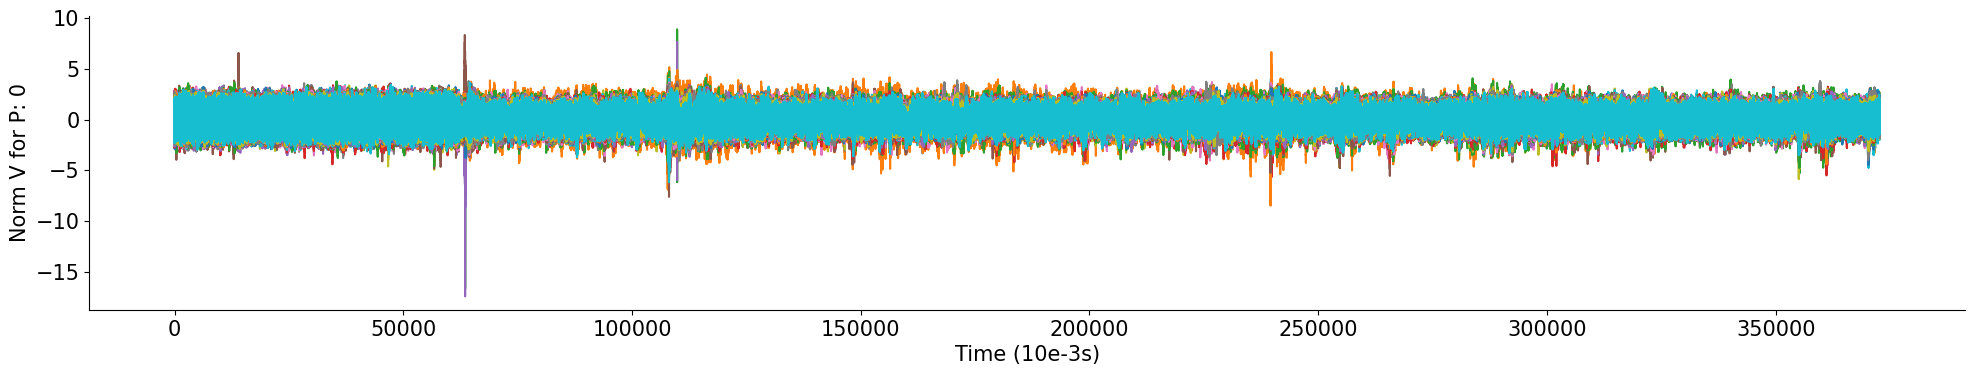

In [6]:
PATIENT_NUMBER = 0

dat = alldat[0][PATIENT_NUMBER]
V = dat['V'].astype('float16')

nt, nchan = V.shape

plt.plot(V)
plt.xlabel('Time (10e-3s)')
plt.ylabel(f'Norm V for P: {PATIENT_NUMBER}')

plt.show()

In [7]:
# Author: Akira Kudo
# Created: -
# Last updated: 2024/03/10

def datatype_per_patient(patient_num):
  print(f"PATIENT {i}")
  patient = alldat[0][patient_num]
  printed = " ".join(
      [f"({k} : {patient[k].dtype})" if isinstance(patient[k], np.ndarray) else ""
      for k in patient.keys()])
  print(printed)


print("DATATYPE:")
for i in range(len(alldat[0])):
  datatype_per_patient(i)

DATATYPE:
PATIENT 0
(V : float16) (targetX : uint16) (targetY : uint16) (cursorX : uint16) (cursorY : uint16) (locs : float64)    
PATIENT 1
(V : float16) (targetX : uint16) (targetY : uint16) (cursorX : uint16) (cursorY : uint16) (locs : float64)    
PATIENT 2
(V : float16) (targetX : uint16) (targetY : uint16) (cursorX : uint16) (cursorY : uint16) (locs : float64)    
PATIENT 3
(V : float16) (targetX : uint16) (targetY : uint16) (cursorX : uint16) (cursorY : uint16) (locs : float64)    


In [8]:
# Author: Akira Kudo
# Created: -
# Last updated: 2024/03/10

def description_for_patient_i(i):
  print(f"FOR PATIENT {i}:")
  patient = alldat[0][i]

  assert(patient['V'].shape[0]       == patient['targetX'].shape[0] and
         patient['targetX'].shape[0] == patient['targetY'].shape[0] and
         patient['targetY'].shape[0] == patient['cursorX'].shape[0] and
         patient['cursorX'].shape[0] == patient['cursorY'].shape[0])

  assert(patient['targetX'].shape[1] == 1 and
         patient['targetY'].shape[1] == 1 and
         patient['cursorX'].shape[1] == 1 and
         patient['cursorY'].shape[1] == 1)

  assert(patient['V'].shape[1] == patient['locs'].shape[0])

  num_timepoints, num_channels = patient['V'].shape
  print(f" - Voltage data has {num_timepoints} timepoints and {num_channels} channels.")

  print(f" - Locations of {num_channels} electrodes expressed in {patient['locs'].shape[1]}D.")

  for category_label in ['hemisphere', 'lobe', 'gyrus', 'Brodmann_Area']:
    unique_labels = np.unique(patient[category_label])
    print(f" - Unique labels for {category_label}: \n{unique_labels}.")

  print("___________________________________")


num_patients = len(alldat[0])
# print(f"We have {num_patients} patients in this dataset.")

for i in range(num_patients):
  description_for_patient_i(i)

FOR PATIENT 0:
 - Voltage data has 372760 timepoints and 60 channels.
 - Locations of 60 electrodes expressed in 3D.
 - Unique labels for hemisphere: 
['Left Cerebrum'].
 - Unique labels for lobe: 
['Frontal Lobe' 'Parietal Lobe' 'Temporal Lobe'].
 - Unique labels for gyrus: 
['Inferior Frontal Gyrus' 'Middle Frontal Gyrus' 'Middle Temporal Gyrus'
 'Postcentral Gyrus' 'Precentral Gyrus' 'Superior Frontal Gyrus'
 'Superior Temporal Gyrus'].
 - Unique labels for Brodmann_Area: 
['Brodmann area 10' 'Brodmann area 2' 'Brodmann area 21'
 'Brodmann area 22' 'Brodmann area 3' 'Brodmann area 38' 'Brodmann area 4'
 'Brodmann area 40' 'Brodmann area 42' 'Brodmann area 43'
 'Brodmann area 44' 'Brodmann area 45' 'Brodmann area 46'
 'Brodmann area 47' 'Brodmann area 6' 'Brodmann area 8' 'Brodmann area 9'].
___________________________________
FOR PATIENT 1:
 - Voltage data has 248640 timepoints and 64 channels.
 - Locations of 64 electrodes expressed in 3D.
 - Unique labels for hemisphere: 
['Right 

In [9]:
# Author: Akira Kudo
# Created: -
# Last updated: 2024/03/10

# Given the cursor movement sample rates seems lower than 1000Hz,
# identify sample rate for cursor movement

# first define useful functions
# Counts the number of consecutive true / false blocks
def count_consecutive_true_or_false_block_sizes(arr, countTrue):
  # find positions where a new block begins
  block_start = np.concatenate(([True], arr[:-1] != arr[1:]))
  # get block lengths based on that
  block_lengths = np.diff(
      np.append( np.where(block_start)[0], len(arr))
      )
  # count block sizes of interest
  count_start = 0 if (countTrue == arr[0]) else 1
  counting_block_sizes = block_lengths[count_start::2]
  return counting_block_sizes

def SanityCheck_count_consecutive_true_or_false_block_sizes():
  block_sizes = [3,2,5,1,20,3]; initial_val = False
  initial_val_blocks = [3,5,20]; opposite_val_blocks = [2,1,3]
  arr = np.concatenate(
      [np.array([i % 2 != 0] * block_sizes[i])
      for i in range(0, len(block_sizes))]
  )
  np.testing.assert_array_equal(opposite_val_blocks,
      count_consecutive_true_or_false_block_sizes(arr, not initial_val))
  np.testing.assert_array_equal(initial_val_blocks,
      count_consecutive_true_or_false_block_sizes(arr, initial_val))

SanityCheck_count_consecutive_true_or_false_block_sizes()

# then use it
def check_window_sizes(patient_num):
  print(f"PATIENT {patient_num}: ")
  def check_for_window_size_given_one_array(arr):
    # indices at which values are different from immediate previous
    # * 1st entry is considered different
    block_starts = np.insert(np.ediff1d(arr).astype(bool), 0, True)

    likely_window_sizes = count_consecutive_true_or_false_block_sizes(block_starts, False) + 1
    unique_window_sizes = np.unique(likely_window_sizes)
    print("Unchanging window sizes found: \n", unique_window_sizes)
    # at this point, we can see that values are all multiples of 40
    assert np.prod(np.mod(unique_window_sizes, 40) == 0) == 1, \
           f"Some window size for patient {patient_num} isn't a multiple of 40: " + \
           f"{arr}."

  cursorX = alldat[0][patient_num]["cursorX"]
  cursorY = alldat[0][patient_num]["cursorY"]
  targetX = alldat[0][patient_num]["targetX"]
  targetY = alldat[0][patient_num]["targetY"]

  check_for_window_size_given_one_array(cursorX)
  check_for_window_size_given_one_array(cursorY)
  check_for_window_size_given_one_array(targetX)
  check_for_window_size_given_one_array(targetY)

for patient_num in range(len(alldat[0])):
  check_window_sizes(patient_num)

PATIENT 0: 
Unchanging window sizes found: 
 [  40   80  120  160  200  240  280  320  360  400  440  480  520  560
  600  640  680  720  800  840  880  920 1040 1160 1200 1280 1440 2080
 2120]
Unchanging window sizes found: 
 [  40   80  120  160  200  240  280  320  360  400  440  480  520  600
  640  680  760  800  840 1080 1200 2080 2120 2200]
Unchanging window sizes found: 
 [  40 2080 2120]
Unchanging window sizes found: 
 [  40   80 2080 2120]
PATIENT 1: 
Unchanging window sizes found: 
 [  40   80  120  160  200  240  280  360  400  440  480  520  600  640
  720  760  800  840  880  920 1000 1040 1120 1200 1360 1720 1800 2080]
Unchanging window sizes found: 
 [  40   80  120  160  200  240  280  320  360  400  440  480  520  560
  600  640  720  760  920 1040 1080 1120 1200 1240 1440 1480 1520 1720
 2080]
Unchanging window sizes found: 
 [  40 2080]
Unchanging window sizes found: 
 [  40   80 2080]
PATIENT 2: 
Unchanging window sizes found: 
 [  40   80  120  160  200  240  280

## Dataset Visualization

### Joystick Data

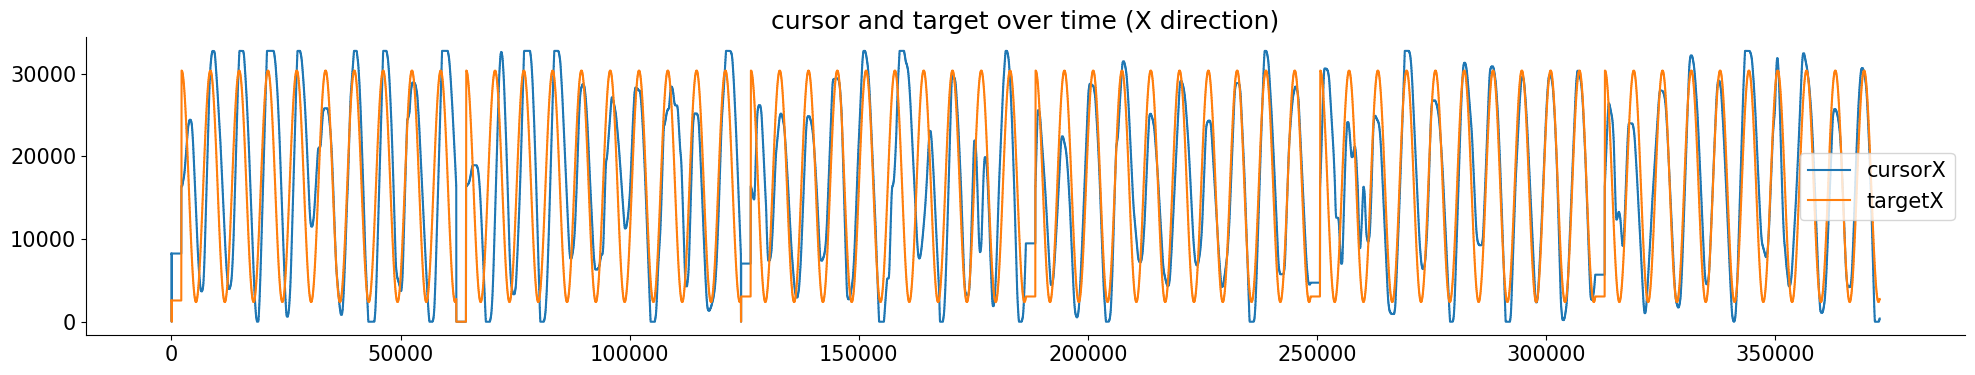

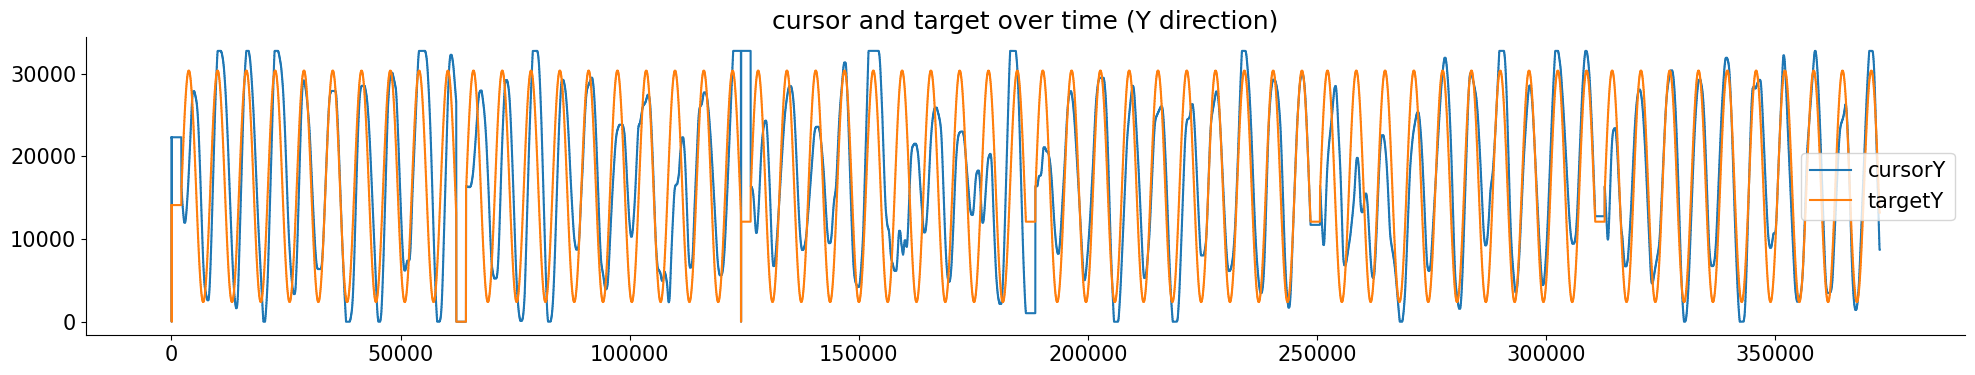

In [10]:
# plot cursor data
dat = alldat[0][0]

plt.figure(1)
plt.plot(dat['cursorX'], label='cursorX')
plt.plot(dat['targetX'], label='targetX')
plt.title('cursor and target over time (X direction)')
plt.legend()

plt.figure(2)
plt.plot(dat['cursorY'], label='cursorY')
plt.plot(dat['targetY'], label='targetY')
plt.title('cursor and target over time (Y direction)')
plt.legend()

plt.show()

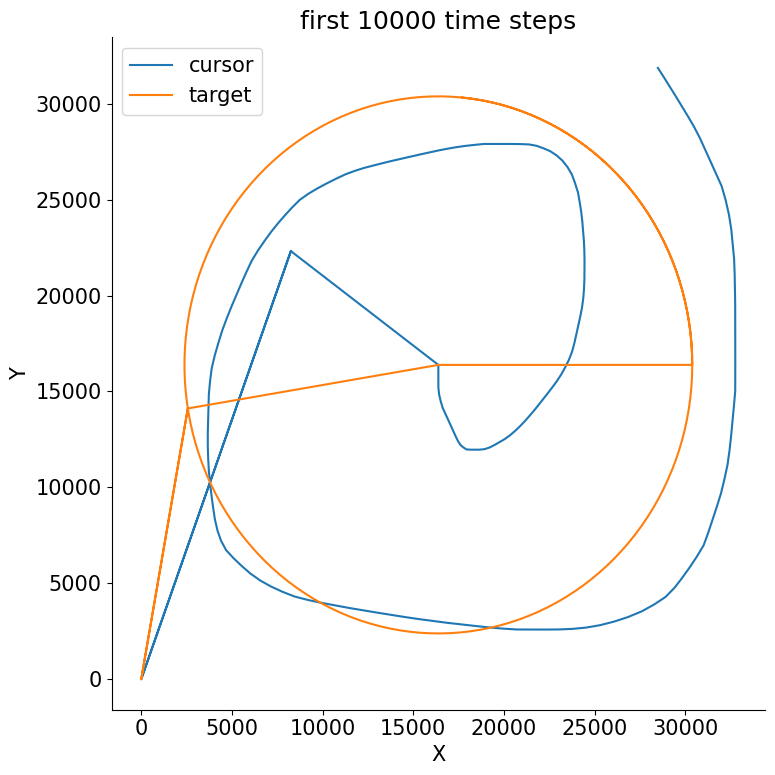

In [11]:
plt.figure(3, figsize=(8, 8))
plt.plot(dat['cursorX'][:10000], dat['cursorY'][:10000], label='cursor')
plt.plot(dat['targetX'][:10000], dat['targetY'][:10000], label='target')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('first 10000 time steps')
plt.legend()
plt.show()

In [12]:
# Author: Akira Kudo
# Created: -
# Last updated: 2024/03/10

CALCULATION_DATATYPE = np.float32

# Add labels based on X, Y directions of cursor at each point in time
# At each time point, the cursor position is simulated as:
# 1) direction as the direction from current position to next position
# 2) distance from center as speed between time points
# 2's definition is quite arbitrary - but we believe it is not an issue,
# given we only consider the overall stick direction 1 as label.
# Returns speed and direction (counter-clockwise starting from east direction
# in radians) between each time point
def get_speed_and_direction(cursorX : np.ndarray, cursorY : np.ndarray,
                            xLimits=( float("-inf"), float("inf")),
                            yLimits=( float("-inf"), float("inf"))):
  if type(xLimits) not in [type([]), type(())] or len(xLimits) != 2:
    print("xLimits must be a list/tuple with length 2; try again!")
    return
  elif type(yLimits) not in [type([]), type(())] or len(yLimits) != 2:
    print("yLimits must be a list/tuple with length 2; try again!")
    return
  else:
    xUpperbound = max(xLimits); xLowerbound = min(xLimits)
    yUpperbound = max(yLimits); yLowerbound = min(yLimits)

  cursorX = cursorX.astype(CALCULATION_DATATYPE)
  cursorY = cursorY.astype(CALCULATION_DATATYPE)
  # filter based on x/y limits
  cursorX[(cursorX > xUpperbound) | (cursorX < xLowerbound)] = np.nan
  cursorY[(cursorY > yUpperbound) | (cursorY < yLowerbound)] = np.nan
  # compute speed & direction between each time point
  diffX = np.ediff1d(cursorX); diffY = np.ediff1d(cursorY)
  speedSq = np.square(diffX) + np.square(diffY)
  speed = np.sqrt(speedSq)
  # direction
  direction = np.arctan2(diffY, diffX)
  direction = np.mod(direction + 2*np.pi, 2*np.pi) # 0 <= dir <= 2pi
  return speed, direction

def SanityCheck_get_speed_and_direction():
  # try 30, 45, 60, 120, 135, 150, 210, 225, 240, 300, 315 and 330 degrees
  PI = np.pi; angles = [  PI/6,   PI/4, 2*PI/6,  4*PI/6, 3*PI/4,  5*PI/6,
                        7*PI/6, 5*PI/4, 8*PI/6, 10*PI/6, 7*PI/4, 11*PI/6]
  # try 1, 2 and 3 speeds
  distances = [1,2,3]

  for angle in angles:
    for distance in distances:
      x = np.array([0, distance*np.cos(angle)]).astype(CALCULATION_DATATYPE)
      y = np.array([0, distance*np.sin(angle)]).astype(CALCULATION_DATATYPE)
      speed, direction = get_speed_and_direction(x, y)
      np.testing.assert_almost_equal(distance,  speed, decimal=5)
      np.testing.assert_almost_equal(angle, direction, decimal=5)

SanityCheck_get_speed_and_direction()

In [13]:
# Author: Akira Kudo
# Created: -
# Last updated: 2024/03/10

# Plots joy stick position over time, with points progressively increasing in
# shade darkness for later time points
def plot_figure_over_time(X : np.ndarray, Y : np.ndarray,
                          start : int, end : int, figureName : str):
  blueColor = plt.cm.Blues(np.linspace(0.1,1,(end-start)))
  fig,ax = plt.subplots(figsize=(6,6))
  for k in range(end - start):
    if k + 1 > len(X): break
    ax.plot(X[k:k+2], Y[k:k+2], color=blueColor[k])
  plt.xlabel('X'); plt.ylabel('Y')
  plt.title(figureName)
  plt.xlim(np.nanmin(X), np.nanmax(X)); plt.ylim(np.nanmin(Y), np.nanmax(Y))
  plt.show()

In [14]:
# Author: Akira Kudo
# Created: -
# Last updated: 2024/03/10

import os
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import math

# Plots and saves a gif of the change of an object's X/Y position over time
# X/Y : List of plot data over time
# plot_every_n : Plot 1 every N values of the X, Y inputs.
# figurepath : path to saving for gif, including name and extension
# doSave : whether to save the gif
# addProgressBar : whether to add a "progress bar" rendering
def plot_and_save_gif(X, Y, plot_every_n : int, figurepath : str,
                      doSave : bool=True, addProgressBar : bool = True,
                      trail_length : int = None):

  xLowerbound, xUpperbound = np.nanmin(X), np.nanmax(X)
  yLowerbound, yUpperbound = np.nanmin(Y), np.nanmax(Y)
  # Calculate how often we plot
  number_of_rendered_frames = len(X) // plot_every_n
  # Create the figure and axes objects
  fig, ax = plt.subplots(figsize=(6,6))
  # Set the initial plot
  plt.title(f"{os.path.basename(figurepath)}")
  plt.xlim(xLowerbound, xUpperbound)
  plt.ylim(yLowerbound, yUpperbound)
  data = ax.plot(X[0], Y[0], animated=True)[0]

  # Set up progress bar
  if addProgressBar:
    progressBarXMin = -0.8; progressBarXMax = 0.8; progressBarY = -0.8

    progressBarMiddle = (progressBarXMax + progressBarXMin) / 2
    progressBar = ax.plot(progressBarXMin, progressBarY, animated=True)[0]
    progressBarX = [(progressBarXMax - progressBarXMin) / number_of_rendered_frames * x -
                    progressBarXMin
                    for x in range(number_of_rendered_frames)]

  def update(i):
      plot_up_to = min(i * plot_every_n, len(X))

      if trail_length is None:
        plot_from = 0
      else:
        plot_from = max(plot_up_to - trail_length, 0)

      data.set_data(X[plot_from:plot_up_to], Y[plot_from:plot_up_to])

      if addProgressBar:
        progressBar.set_data(progressBarX[:i], [progressBarY]*i)
        return (data, progressBar)
      else:
        return (data,)

  # Create the animation object
  animation_fig = animation.FuncAnimation(
      fig, update, frames=math.ceil(len(X) / plot_every_n), interval=30,
      blit=True, repeat_delay=10
      )

  # Show the animation
  plt.show()
  if doSave:
    animation_fig.save(figurepath)

In [15]:
# Author: Akira Kudo
# Created: -
# Last updated: 2024/03/10

# Plots and saves a gif of the change of the cursor and joystick X/Y position
# over time
# cursorX/cursorY : List of cursor plot data over time
# joystickX/joystickY : List of joystick plot data over time
# plot_every_n : Plot 1 every N values of the X, Y inputs.
# figurepath : path to saving for gif, including name and extension
# doSave : whether to save the gif
# addProgressBar : whether to add a "progress bar" rendering
def plot_and_save_cursor_and_joystick_gif(cursorX, cursorY, joystickX, joystickY,
                                          plot_every_n : int, figurepath : str,
                                          doSave : bool=True,
                                          addProgressBar : bool = True,
                                          trail_length : int = None):

  xCursorLowerbound, xCursorUpperbound = np.nanmin(cursorX), np.nanmax(cursorX)
  yCursorLowerbound, yCursorUpperbound = np.nanmin(cursorY), np.nanmax(cursorY)
  xJoystickLowerbound, xJoystickUpperbound = np.nanmin(joystickX), np.nanmax(joystickX)
  yJoystickLowerbound, yJoystickUpperbound = np.nanmin(joystickY), np.nanmax(joystickY)
  # Calculate how often we plot
  assert len(cursorX) == len(cursorY)
  assert len(joystickX) == len(joystickY)
  totalOriginalFrames = max(len(cursorX), len(joystickX))
  number_of_rendered_frames = totalOriginalFrames // plot_every_n
  # Create the figure and axes objects
  fig, (c_ax, j_ax) = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
  plt.title(f"{os.path.basename(figurepath)}")
  # Set the initial cursor plot
  c_ax.set_xlim(xCursorLowerbound, xCursorUpperbound)
  c_ax.set_ylim(yCursorLowerbound, yCursorUpperbound)
  c_data = c_ax.plot(cursorX[0], cursorY[0], animated=True)[0]
  # Set the initial joystick plot
  j_ax.set_xlim(xJoystickLowerbound, xJoystickUpperbound)
  j_ax.set_ylim(yJoystickLowerbound, yJoystickUpperbound)
  j_data = j_ax.plot(joystickX[0], joystickY[0], animated=True)[0]

  # Set up progress bar
  if addProgressBar:
    progressBarXMin = -0.8; progressBarXMax = 0.8; progressBarY = -0.8
    progressBar = j_ax.plot(progressBarXMin, progressBarY, animated=True)[0]
    progressBarX = [(progressBarXMax - progressBarXMin) /
                    number_of_rendered_frames * x +
                    progressBarXMin
                    for x in range(number_of_rendered_frames)]

  def update(i):
      plot_up_to = min(i * plot_every_n, totalOriginalFrames)

      if trail_length is None:
        plot_from = 0
      else:
        plot_from = max(plot_up_to - trail_length, 0)

      c_data.set_data(  cursorX[plot_from:plot_up_to],   cursorY[plot_from:plot_up_to])
      j_data.set_data(joystickX[plot_from:plot_up_to], joystickY[plot_from:plot_up_to])
      if addProgressBar:
        progressBar.set_data(progressBarX[:i], [progressBarY]*i)
        return (c_data, j_data, progressBar)
      else:
        return (c_data, j_data)

  # Create the animation object
  animation_fig = animation.FuncAnimation(
      fig, update, frames=math.ceil(totalOriginalFrames / plot_every_n),
      interval=100, blit=True, repeat_delay=10
      )

  # Show the animation
  plt.show()
  if doSave:
    animation_fig.save(figurepath)

In [16]:
# Author: Akira Kudo
# Created: -
# Last updated: 2024/03/10

# Define a standardized way of processing cursor data, so as to obtain labels
# from them
def process_cursor_data(patient_data, label_binsize : int):
  cursorX = patient_data["cursorX"][::label_binsize]
  cursorY = patient_data["cursorY"][::label_binsize]
  # set ledges so that we exclude joystick position when cursor reaches
  # ledges of screen
  ledgesX = (np.nanmin(cursorX)+1, np.nanmax(cursorX)-1)
  ledgesY = (np.nanmin(cursorY)+1, np.nanmax(cursorY)-1)

  speed, direction = get_speed_and_direction(
      cursorX, cursorY, xLimits=ledgesX, yLimits=ledgesY
      )
  # ARBITRARY REMOVAL OF VALUES OF SPEED OVER 10000; THIS MAKES THE GRAPH MUCH
  # MORE EASY TO UNDERSTAND
  speed[speed > 10000] = 0
  norm_speed = speed / np.nanmax(speed) # normalize between 0 and 1

  # plt.hist(speed)
  # plt.yscale('log')
  # plt.show

  # compute position of joy stick from speed & direction
  joystickX = norm_speed * np.cos(direction)
  joystickY = norm_speed * np.sin(direction)

  return speed, direction, joystickX, joystickY

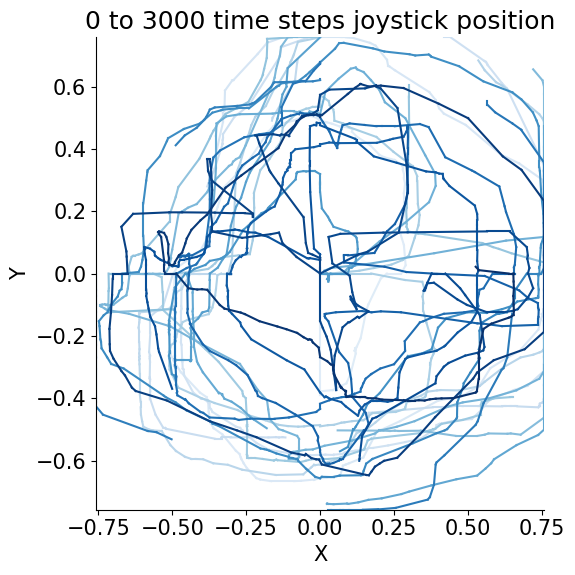

In [17]:
# Plot joystick and cursor position side by side

# SETUP
start = 0
end = start + 3000

patient = alldat[0][0]
cursorX = patient["cursorX"][::TIMEPOINTS_PER_CURSOR_UPDATE]
cursorY = patient["cursorY"][::TIMEPOINTS_PER_CURSOR_UPDATE]

speed, direction, joystickX, joystickY = process_cursor_data(
    patient_data=patient,
    label_binsize=TIMEPOINTS_PER_CURSOR_UPDATE)

end = min(end, len(speed))

# PLOT
plot_figure_over_time(
    joystickX, joystickY, start, end,
    f'{start} to {min(end, len(joystickY))} time steps joystick position'
    )

# # rendering only joystick
# FIGURE_PATH = "joystick_movement.gif"
# plot_and_save_gif(joystickX[start:end], joystickY[start:end],
#                   plot_every_n=10, figurepath=FIGURE_PATH, doSave=True,
#                   addProgressBar=True, trail_length=10*10)
# # rendering both cursor and joystick
# FIGURE_PATH = "cursor_and_joystick_movement.gif"
# plot_and_save_cursor_and_joystick_gif(
#       cursorX[start:end],   cursorY[start:end],
#     joystickX[start:end], joystickY[start:end],
#     plot_every_n=10, figurepath=FIGURE_PATH, doSave=True,
#     addProgressBar=True, trail_length=10*10)

### ECoG Data

## Dataset Labeling

What we need to get decided:

1.   What processing to further do on the data of format ```[patient x electrode x channel x time]```, aka general processing?

2.   What features to extract (and how) from those features? e.g. Binning, feature extraction based on correlation, calculation of general features like local motor potential

3. How to put those into a dataset that is loadable into pytorch? Pytorch customizable dataloaders can really load any format - maybe a numpy file is appropriate for our case. -> store post-processing datasets in the form of ```[patient x feature x bins]```, with labels, ready to be loaded?




In [18]:
# Author: Akira Kudo
# Created: -
# Last updated: 2024/03/10

# TRIAL IMPLEMENTATION OF CUSTOM DATASET WILL COME HERE
# USING [https://pytorch.org/tutorials/beginner/basics/data_tutorial.html] AS EXAMPLE

from typing import Dict

def bin_data_to_binsize(data : Dict,
                        binsize : int,
                        stepsize : int,
                        show_conversion : bool = False):
  """
  Bins numpy arrays given as dictinary of data into given bin sizes
  e.g. for a time series of [n x m] and bin size k and step size l, we produce a
       [num_bins x k x m] array with entries ready for analysis
       Here, num_bins = (n - k) // l + 1
  """
  returned = {}

  if binsize % TIMEPOINTS_PER_CURSOR_UPDATE != 0:
    print(f"You specified bin datasize {binsize} which isn't a multiple of " +
          f"the frequency of cursor update that is {TIMEPOINTS_PER_CURSOR_UPDATE}. ")

  if binsize < TIMEPOINTS_PER_CURSOR_UPDATE:
    print(f"You specified bin datasize {binsize} which is smaller than " +
          f"the frequency of cursor update that is {TIMEPOINTS_PER_CURSOR_UPDATE}. ")
    print("Labels associated to this binning might not have a meaningful interpretation.")

  for key, d in data.items():
    binned_d = bin_array_using_binsize_and_stepsize(arr=d,
                                                    binsize=binsize,
                                                    stepsize=stepsize)
    returned[f'{key}_binned'] = binned_d

    if show_conversion:
      print(f"After reshaping: {binned_d.shape}")
      print(f"Before reshaping: {d.shape}")

  return returned


# Helper
def bin_array_using_binsize_and_stepsize(arr : np.ndarray,
                                         binsize : int,
                                         stepsize : int):
    arrsz = arr.shape[0]
    # e.g. with array [1,2,3,4,5,6] and binsize=3, stepsize=2, bins are:
    #      [1,2,3], [3,4,5] making truncated array size 5 = (6 - 3) // 2 * 2 + 3
    arrsz = (arrsz - binsize) // stepsize * stepsize + binsize # rounding to nearest number of bins, truncating rest
    arr = arr[:arrsz, ...] # truncate to nearest possible bin size

    # if binsize is equal to stepsize, reshape (for fast performance?)
    if binsize == stepsize:
      newshape = (arrsz // binsize, binsize) + arr.shape[1:]
      binned = arr.reshape(newshape)
    else:
      arr_list = []
      for binstart in range(0, arrsz, stepsize):
        # if entire bin is within arrsz range
        binend = binstart + binsize - 1
        if (binend + 1) <= arrsz:
          arr_list.append(arr[binstart:binend+1])
      binned = np.stack(arr_list, axis=0)

    return binned

def sanity_check_bin_data_to_binsize():
  binsize = TIMEPOINTS_PER_CURSOR_UPDATE * 2
  stepsize = TIMEPOINTS_PER_CURSOR_UPDATE // 2
  # stepsize = TIMEPOINTS_PER_CURSOR_UPDATE * 2
  binned_data = []

  # for each patient index (0~3?)
  for i, patient in enumerate(alldat[0]):
    # likely useful labels: 'V', 'targetX/Y', 'cursorX/Y'
    label_to_bin = ['V']
    tobin = dict([ (key, patient[key]) for key in label_to_bin])
    binned = bin_data_to_binsize(tobin, binsize, stepsize)
    binned_data.append(binned)

  print(f"Chose bin size of {binsize} and step size of {stepsize}!")
  [print(f"patient {i}:", [f"{key} - {patient[key].shape}" for key in patient.keys()])
  for i, patient in enumerate(binned_data)]

  # also sanity check with a simple array
  # [1,2,3,4,5,6], stepsize=2, binsize=3 -> [1,2,3], [3,4,5]
  simple_array = np.array([[1,1],[2,2],[3,3],[4,4],[5,5],[6,6]])
  binned = bin_data_to_binsize({'simple_arr' : simple_array}, binsize=3, stepsize=2)
  # compare expected and actual
  expected_binned = np.array([
      [[1,1],[2,2],[3,3]],
      [[3,3],[4,4],[5,5]]
      ])
  actual_binned = binned['simple_arr_binned']
  assert np.array_equal(expected_binned, actual_binned), "Result from bin_data_to_binsize was unexpected..."
  print("{}: {}".format(*list(binned.items())[0]))

sanity_check_bin_data_to_binsize()

Chose bin size of 80 and step size of 20!
patient 0: ['V_binned - (18635, 80, 60)']
patient 1: ['V_binned - (12429, 80, 64)']
patient 2: ['V_binned - (6715, 80, 64)']
patient 3: ['V_binned - (12993, 80, 48)']
You specified bin datasize 3 which isn't a multiple of the frequency of cursor update that is 40. 
You specified bin datasize 3 which is smaller than the frequency of cursor update that is 40. 
Labels associated to this binning might not have a meaningful interpretation.
simple_arr_binned: [[[1 1]
  [2 2]
  [3 3]]

 [[3 3]
  [4 4]
  [5 5]]]


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in angle_to_quadrant (vectorized)
  outputs = ufunc(*inputs)


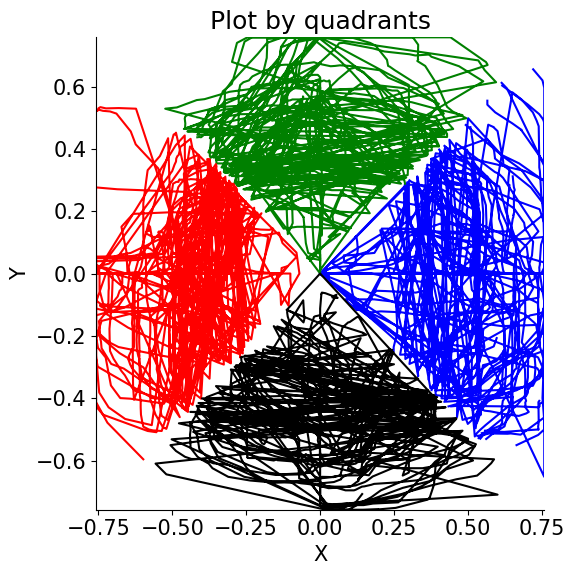

In [19]:
# Author: Akira Kudo
# Created: -
# Last updated: 2024/03/10

# we divide the field into four quadrants; each quadrant is centered around
# the four directions, 1:right, 2:up, 3:left, 4:down.
def label_quadrant(speed : np.ndarray, direction : np.ndarray):
  # TODO - DO SOMETHING WITH SPEED!!
  def angle_to_quadrant(direction):
    if 0 <= direction <= np.pi/4:
      quadrant = 1
    elif np.pi/4 < direction <= np.pi*3/4:
      quadrant = 2
    elif np.pi*3/4 < direction <= np.pi*5/4:
      quadrant = 3
    elif np.pi*5/4 < direction <= np.pi*7/4:
      quadrant = 4
    else:
      quadrant = 1
    return quadrant

  labels = np.vectorize(angle_to_quadrant)(direction)
  return labels

def sanity_check_plot_labels_by_quadrant(X : np.ndarray,
                                         Y : np.ndarray,
                                         label : np.ndarray,
                                         figureName : str):
  fig = plt.figure(figsize=(6,6))
  colors = [None, 'b', 'g', 'r', 'k']
  for quadrant in range(1,5):
    quad_lbl_idx = label==quadrant
    plt.plot(X[quad_lbl_idx], Y[quad_lbl_idx], color=colors[quadrant])
  plt.xlabel('X'); plt.ylabel('Y')
  plt.title(figureName)
  plt.xlim(np.nanmin(X), np.nanmax(X)); plt.ylim(np.nanmin(Y), np.nanmax(Y))
  plt.show()

label = label_quadrant(speed, direction)
sanity_check_plot_labels_by_quadrant(joystickX, joystickY, label, figureName="Plot by quadrants")

In [20]:
# Author: Akira Kudo
# Created: -
# Last updated: 2024/03/10
def get_label_consistency_of_binsize(cursorX : np.ndarray,
                                     cursorY : np.ndarray,
                                     binsize  : int=TIMEPOINTS_PER_CURSOR_UPDATE,
                                     max_multiple : int=10):
  """
  For bin sizes that are up to 'max_multiple' multiple, calculate what fraction
  of the bin is consistent in label.
  :param np.ndarray cursorX: X cursor position extracted from the dataset.
  :param np.ndarray cursorY: Y cursor position extracted from the dataset.
  :param int binsize: Size of bin that is the minimum bin size we investigate.
  :param int max_multiple: Investigate (i * 'binsize') bin sizes, where i is
  between 2 and max_multiple inclusive.
  """
  # first extract labels using binsize
  speed, direction, joystickX, joystickY = process_cursor_data(
    patient_data= { "cursorX" : cursorX, "cursorY" : cursorY},
    label_binsize=binsize)

  labels = label_quadrant(speed, direction)
  consistent_proportions = []
  # then check for multiples of binsize whether the labels match within bins
  for multiplier in range(2, max_multiple+1):
    consistent_bin_count = 0
    # bin the label
    labels_per_position_in_bin = bin_array_using_binsize_and_stepsize(
        arr=labels, binsize=multiplier, stepsize=multiplier)

    # count the number of consistent bins
    for i in range(labels_per_position_in_bin.shape[0]):
      # if bin is consistent
      if np.all(labels_per_position_in_bin[i,0] == labels_per_position_in_bin[i,0:]):
        consistent_bin_count += 1
    # compute the ratio of consistent bins to the total
    consistent_proportions.append(consistent_bin_count / labels_per_position_in_bin.shape[0])

  return consistent_proportions

In [21]:
patient = alldat[0][0]
cursorX, cursorY = patient["cursorX"], patient["cursorY"]
consistent_ratio = get_label_consistency_of_binsize(cursorX, cursorY, binsize=40)
print(consistent_ratio)

[0.9637261214852972, 0.9327108821635544, 0.8948046371833405, 0.8572195383789587, 0.8325820991629105, 0.7896318557475582, 0.7628865979381443, 0.7458937198067633, 0.6938775510204082]


In [22]:
# Author: Akira Kudo
# Created: -
# Last updated: 2024/03/10
def save_npz_bins_and_labels_for_all_patients(original_dataset,
                                              savedir : str,
                                              filename : str="binned_V_and_label",
                                              V_binsize     : int=TIMEPOINTS_PER_CURSOR_UPDATE,
                                              V_stepsize    : int=TIMEPOINTS_PER_CURSOR_UPDATE,
                                              label_binsize : int=TIMEPOINTS_PER_CURSOR_UPDATE):
  """
  Create a npz holding both binned data and their labels for all patients.
  Voltage data will be binned according to both bin and step size.
  A corresponding label array is provided, where a label is applied to the nth
  voltage bin only if it is consistent within the duration, and otherwise a -1
  label is applied.
  :param dict original_dataset: The original dataset, as extracted from
  joystick_track.npz.
  :param str savedir: Directory to save the results to.
  :param str filename: Name of the file we save the result as, which will be
  suffixed with '_Vb{V_binsize}_Vs{V_stepsize}_l{label_binsize}'.
  :param int V_binsize: The size to which we bin voltage data into. Must be a
  multiple of label_binsize. Defaults to TIMEPOINTS_PER_CURSOR_UPDATE, and must
  not be smaller.
  :param int V_stepsize: The step size between two consecutive voltage data bins.
  Must be a multiple of label_binsize. Defaults to TIMEPOINTS_PER_CURSOR_UPDATE,
  and must not be smaller.
  :param int label_binsize: The number of timesteps between two consecutive
  cursor timepoints we use to identify the corresponding label. Recommended to
  leave as default, TIMEPOINTS_PER_CURSOR_UPDATE, and must not be smaller.
  """
  if V_binsize % label_binsize != 0:
    raise Exception(f"V_binsize {V_binsize} must be a multiple of label_binsize {label_binsize}!")
  if V_stepsize % label_binsize != 0:
    raise Exception(f"V_stepsize {V_stepsize} must be a multiple of label_binsize {label_binsize}!")

  toNpz_dict = {}

  for i, patient in enumerate(original_dataset[0]):
    # extract labels first
    speed, direction, joystickX, joystickY = process_cursor_data(
        patient_data=patient,
        label_binsize=label_binsize)
    label = label_quadrant(speed, direction)

    # then bin it according to binsize and stepsize
    labels_per_Vbin, labels_per_Vstep = V_binsize // label_binsize, V_stepsize // label_binsize
    binned_label = bin_array_using_binsize_and_stepsize(arr=label,
                                                        binsize=labels_per_Vbin,
                                                        stepsize=labels_per_Vstep)
    # labels consistent within a bin are preserved, and non-consistent bins are
    # labeled as -1
    consistent_label = []
    for i in range(binned_label.shape[0]):
      # if bin is consistent, keep the label
      if np.all(binned_label[i,0] == binned_label[i,0:]):
        consistent_label.append(binned_label[i,0])
      # if bin isn't consistent, label it with -1
      else:
        consistent_label.append(-1)
    consistent_label = np.array(consistent_label)

    toNpz_dict[f"patient_{i}_label"] = consistent_label
    # also bin dataset into the according format
    label_to_bin = ['V']
    tobin = dict([ (key, patient[key]) for key in label_to_bin])
    V_binned = bin_data_to_binsize(tobin, V_binsize, V_stepsize, show_conversion=True)

    toNpz_dict[f"patient_{i}_V"] = V_binned['V_binned']


  final_filename = f"{filename}_Vb{V_binsize}_Vs{V_stepsize}_l{label_binsize}"
  print(f"Saving {final_filename} under {savedir}.")
  np.savez(os.path.join(savedir, final_filename), **toNpz_dict)
  print("Successful.")


In [23]:
# Actually save an instance of binned data

# save computed result
SAVE_DIR = "."
save_npz_bins_and_labels_for_all_patients(
    alldat,
    savedir=SAVE_DIR,
    filename="binned_V_and_label",
    V_binsize=40,
    V_stepsize=40,
    label_binsize=40
    )

# load and check result
npzfile = np.load("binned_V_and_label_Vb40_Vs40_l40.npz")
print(f"npzfile.files: {npzfile.files}")
for f in npzfile.files:
  print(f"npzfile[{f}].shape: {npzfile[f].shape}")

After reshaping: (9319, 40, 60)
Before reshaping: (372760, 60)
After reshaping: (6216, 40, 64)
Before reshaping: (248640, 64)
After reshaping: (3359, 40, 64)
Before reshaping: (134360, 64)
After reshaping: (6498, 40, 48)
Before reshaping: (259920, 48)
Saving binned_V_and_label_Vb40_Vs40_l40 under ..
Successful.
npzfile.files: ['patient_9317_label', 'patient_9317_V', 'patient_6214_label', 'patient_6214_V', 'patient_3357_label', 'patient_3357_V', 'patient_6496_label', 'patient_6496_V']
npzfile[patient_9317_label].shape: (9318,)
npzfile[patient_9317_V].shape: (9319, 40, 60)
npzfile[patient_6214_label].shape: (6215,)
npzfile[patient_6214_V].shape: (6216, 40, 64)
npzfile[patient_3357_label].shape: (3358,)
npzfile[patient_3357_V].shape: (3359, 40, 64)
npzfile[patient_6496_label].shape: (6497,)
npzfile[patient_6496_V].shape: (6498, 40, 48)


In [24]:
patient = alldat[0][0]

speed, direction, joystickX, joystickY = process_cursor_data(
    patient_data=patient, label_binsize=TIMEPOINTS_PER_CURSOR_UPDATE)

labels = label_quadrant(speed, direction)

## Feature Extraction
----------
Copying this paper [here](https://iopscience.iop.org/article/10.1088/1741-2552/ac4ed1/pdf):

**Lin Yao et al (2022). Fast and accurate decoding of finger movements
from ECoG through Riemannian features and
modern machine learning techniques**

<br>

Signal from each electrode are:
*   Common average referenced
*   Divided into 200 ms epochs with 40 ms steps <- *ROOM FOR TWEAKING*

Extracted features:
*   alpha (8–13 Hz)
*   beta (13–30 Hz)
*   low-gamma (30–60 Hz)
*   gamma (60–100 Hz)
*   high-gamma (100–200 Hz) power
*   LMPs - running average of raw ECoG for each channel
*   Hjorth activity, mobility & complexity parameters - statistical properties: variance (activity), mean frequency (mobility) & changes in frequency over a given time period (complexity)

In [25]:
# Author: Akira Kudo
# Created: 2024/03/13
# Last updated: 2024/03/13

def common_average_reference(V_data : np.ndarray, channel_axis : int=-1):
    """
    Computes the common average referenced voltage data, which allows removal
    of non-local brain activity to be removed and enhances signals.
    For each time point t, the common-average-referenced voltage data for
    channel n, t_rn is computed as:
    t_rn = t_n - 1/N * (Sum from i=1~N) t_N
    where t_n is the raw voltage data from channel n and we have N channels.
    :param np.ndarray V_data: Voltage data which we common-average-reference.
    :param int channel_axis: The axis that holds the channel dimension.
    Defaults to -1.
    """
    common_average = np.mean(V_data, axis=channel_axis, keepdims=True)
    cmn_avg_rfr = V_data - common_average
    return cmn_avg_rfr

def sanity_check_common_averge_reference():
   pre_reference  = np.array([[ 0,1,2], [ 1,3,5], [ 4,7,10], [1,1,1]])
   post_reference = np.array([[-1,0,1], [-2,0,2], [-3,0, 3], [0,0,0]])
   cmn_avg_rfr = common_average_reference(pre_reference)
   assert np.array_equal(cmn_avg_rfr, post_reference)
   print(f"Original array: {pre_reference}")
   print(f"Common-average-referenced: {cmn_avg_rfr}")

sanity_check_common_averge_reference()

Original array: [[ 0  1  2]
 [ 1  3  5]
 [ 4  7 10]
 [ 1  1  1]]
Common-average-referenced: [[-1.  0.  1.]
 [-2.  0.  2.]
 [-3.  0.  3.]
 [ 0.  0.  0.]]


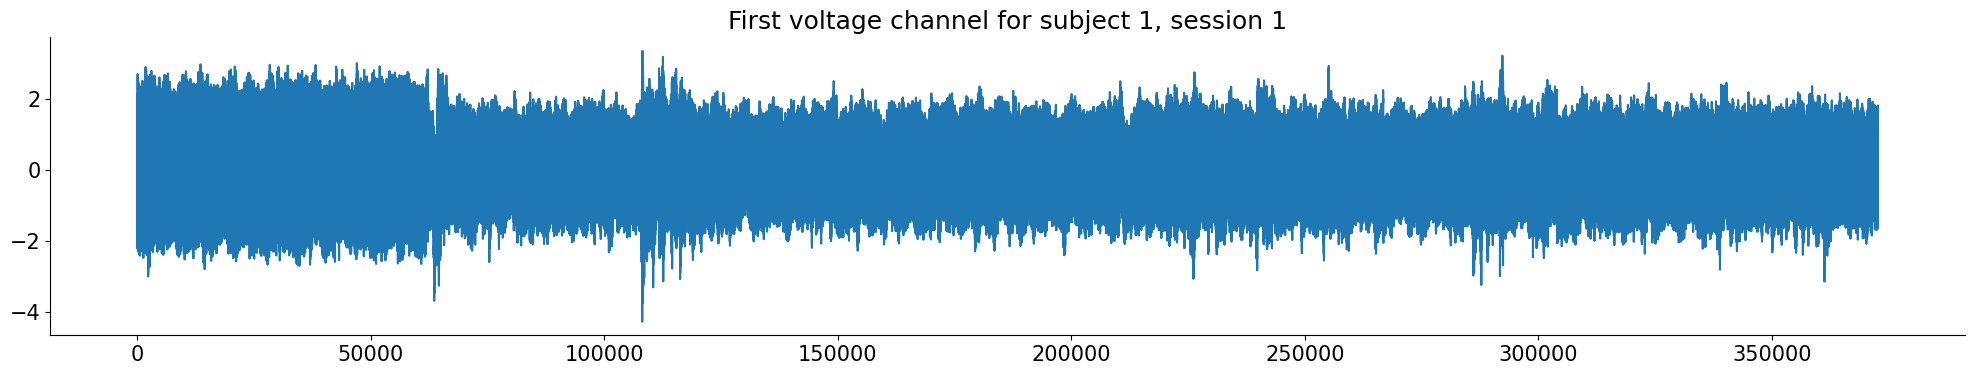

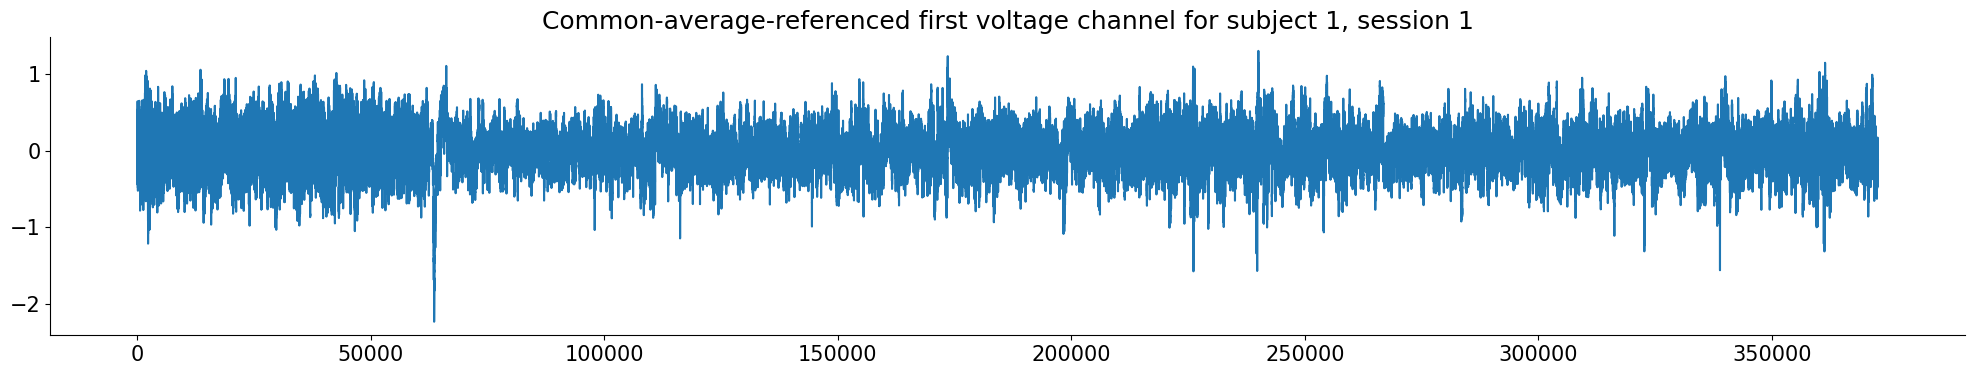

In [26]:
patient = alldat[0][0]

plt.plot(patient['V'][:, 0])
plt.title("First voltage channel for subject 1, session 1")
plt.show()

V_cm_avg_ref = common_average_reference(V_data=patient['V'])

plt.plot(V_cm_avg_ref[:, 0])
plt.title("Common-average-referenced first voltage channel for subject 1, session 1")
plt.show()

### Frequency Features

The wave ranges 0.0-188.5, sampled 3000 times.
Just added wave of frequency 10 and amplitude 5!


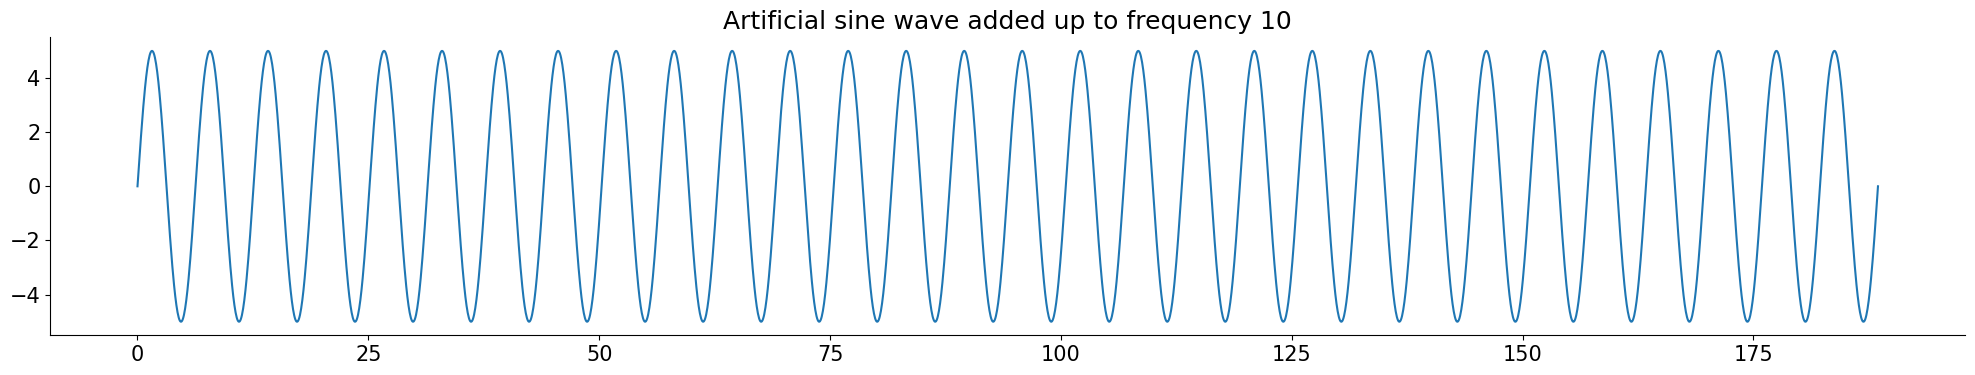

The wave ranges 0.0-377.0, sampled 3000 times.
Just added wave of frequency 20 and amplitude 4!


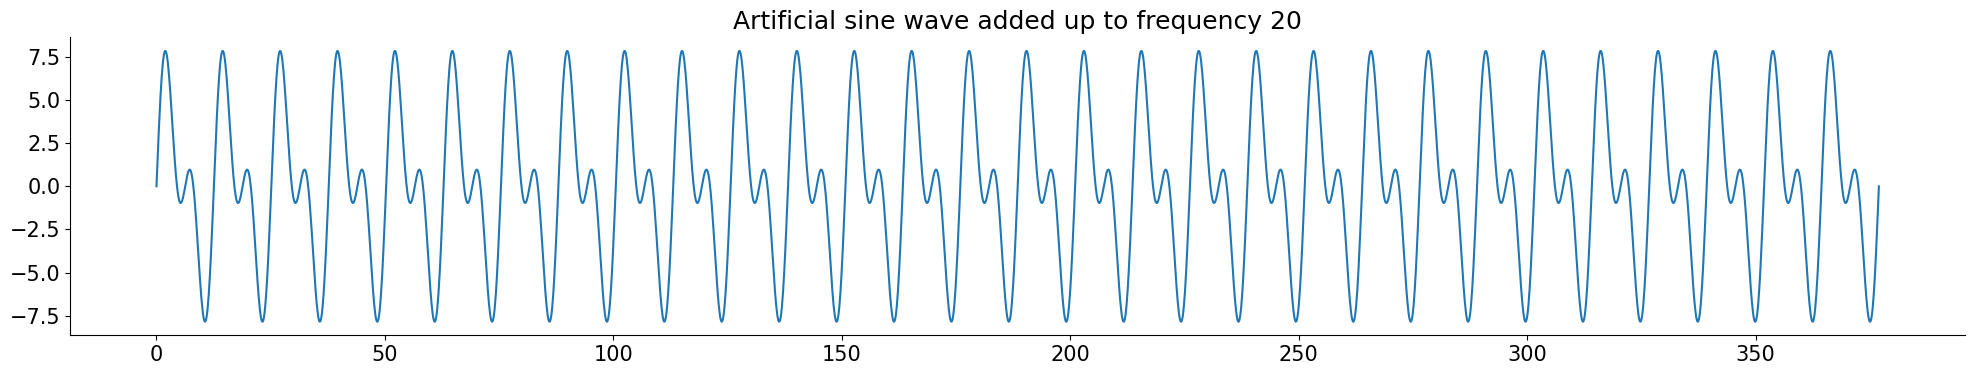

The wave ranges 0.0-848.2, sampled 3000 times.
Just added wave of frequency 45 and amplitude 3!


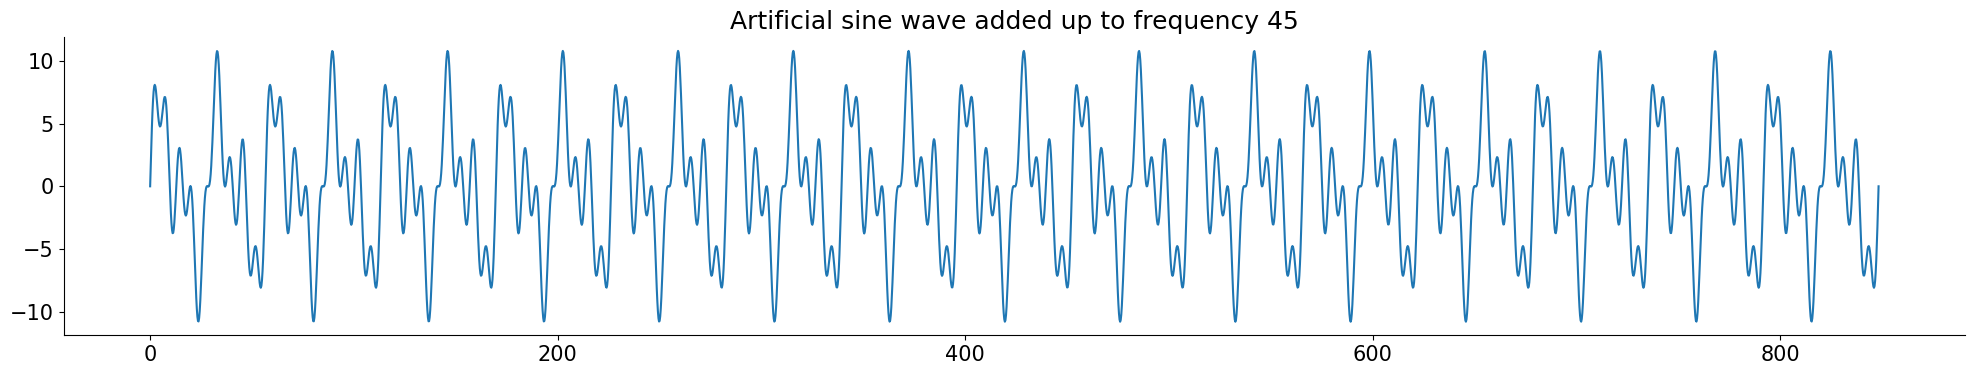

The wave ranges 0.0-1508.0, sampled 3000 times.
Just added wave of frequency 80 and amplitude 2!


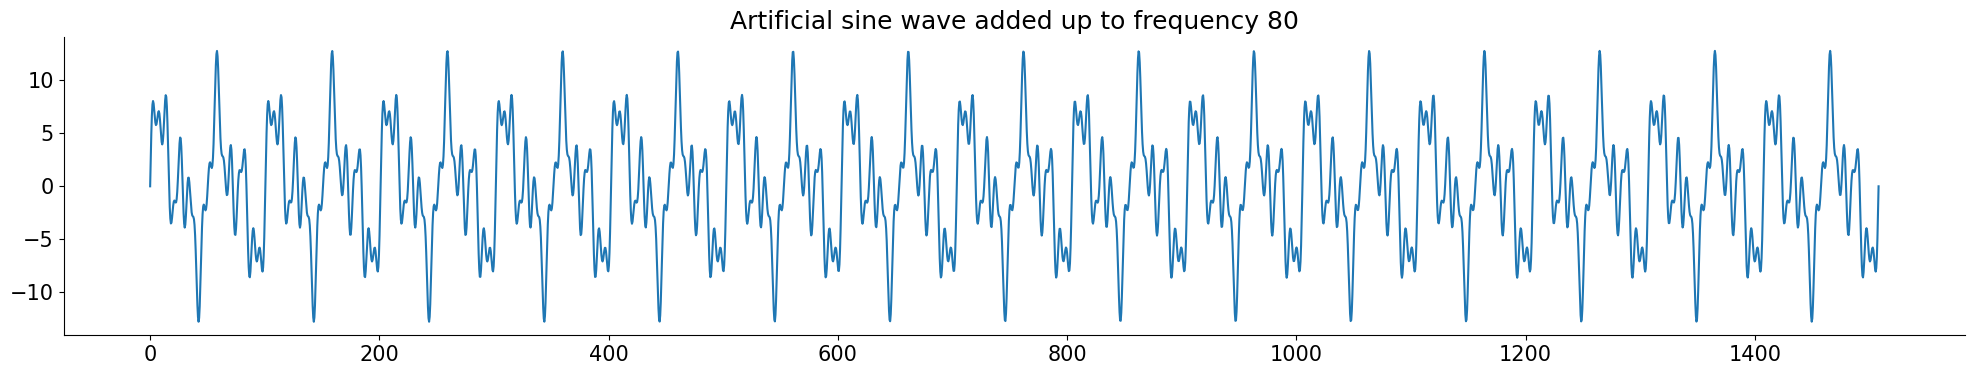

The wave ranges 0.0-2827.4, sampled 3000 times.
Just added wave of frequency 150 and amplitude 1!


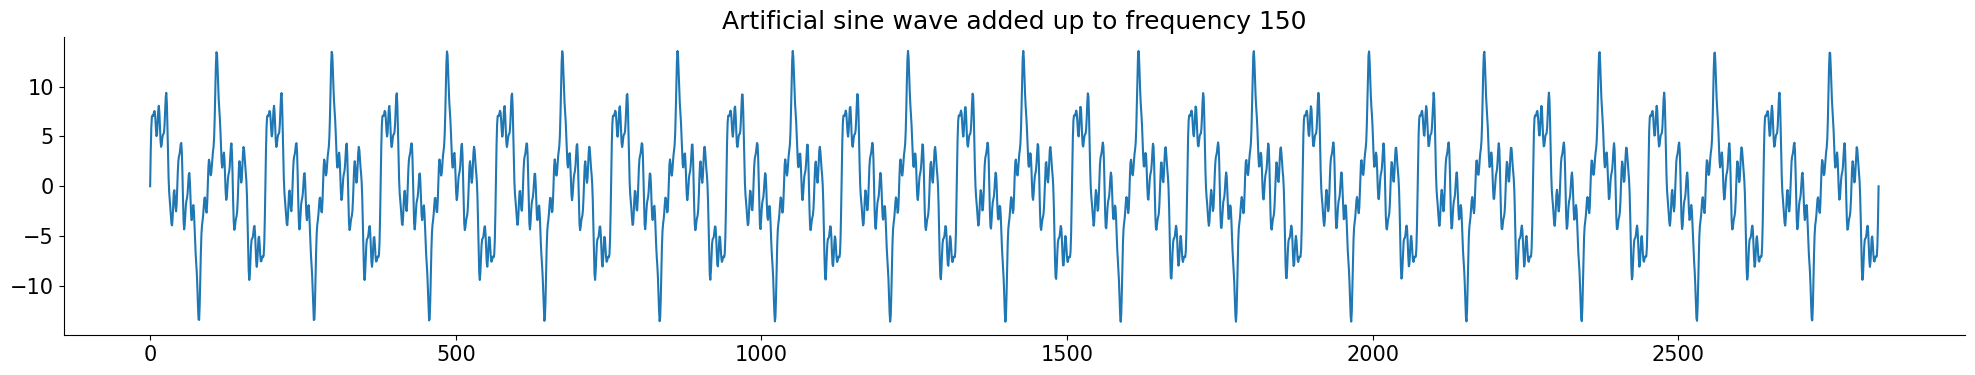

After reshaping: (71, 200, 1)
Before reshaping: (3000, 1)
The expected 'bin-centers : amplitudes' are: ['10:5', '20:4', '45:3', '80:2', '150:1']


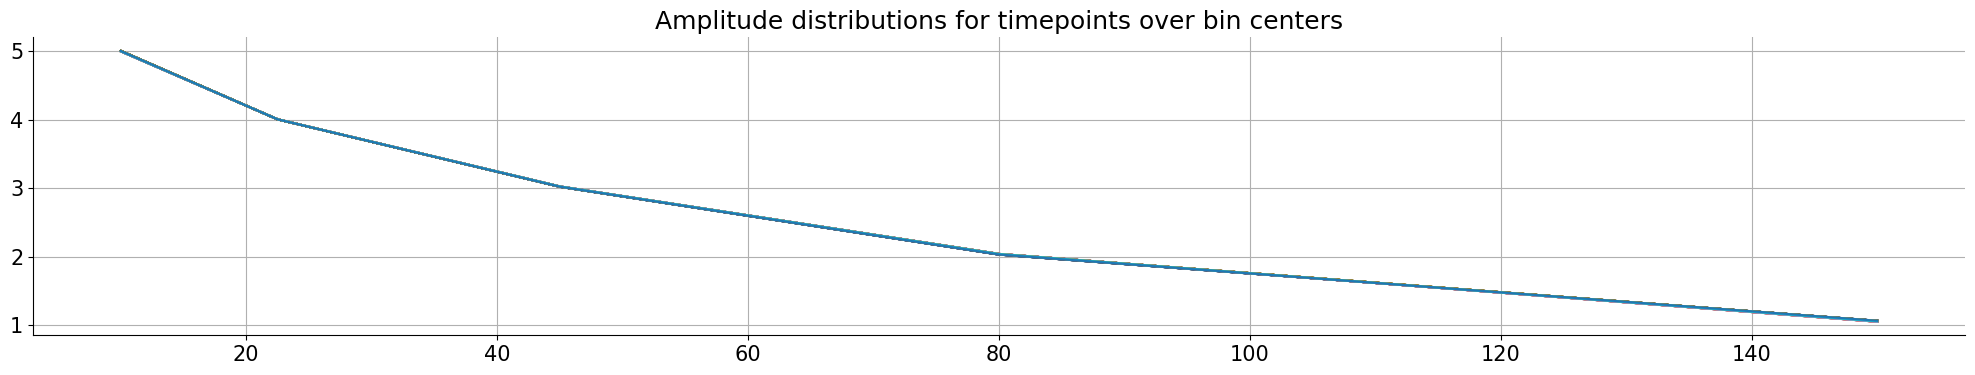

In [66]:
# Author: Akira Kudo
# Created: 2024/03/10
# Last updated: 2024/03/23

from typing import Tuple

# Conversion into frequency domain: can be done 1) by bins, or 2) for whole signal?
# My vague understanding: smaller window = sharper signals, but less bands. Using
#  larger windows will in turn yield many bands, but fails to capture momentous
#  frequencies within the data. So we might wanna focus on smaller bins?
#  Source on windowsize: [https://digitalsoundandmusic.com/2-3-10-windowing-the-fft/#:~:text=There's%20a%20tradeoff%20in%20the,size%20N%20is%20N%2F2.]
def extract_frequency_features_from_binned_voltage(
    binned_V : np.ndarray,
    frequency_ranges : Tuple[Tuple[int]]
    ):
    """
    Extract frequency features specified under 'frequency_ranges', given an
    already binned voltage data. Fast fourier transform is used to convert
    individual bins into their frequency domain.
    :param np.ndarray binned_V: A binned voltage data array, of shape
    [binnumber x binsize x channelsize].
    :param Tuple[Tuple[int]] frequency_ranges: A tuple of tuple of integer
    expressing the frequency ranges as ((low, high), (low, high), ...) etc.
    Corresponding frequency ranges will be extracted, where the size of frequency
    bins is determined by the bin size N of voltage data (N/2, if I understand correctly?)

    I checked out https://docs.scipy.org/doc/scipy-1.11.4/tutorial/fft.html#d-discrete-fourier-transforms
    for understanding how to apply fourier transforms from scipy.
    """
    frequency_result, exact_freq_ranges = [], []

    binsize = binned_V.shape[1]
    # use rfft as we have real-valued inputs; speed up!
    frequency_domain = fft.rfft(binned_V, axis=1)[:,1:,:] # exclude first term which isn't useful??
    frequency_bincenters = fft.fftfreq(n=binsize, d=1/SAMPLE_RATE)
    # truncate frequency_bincenters given it also returns negative frequency bins
    pos_freq_bincenters = frequency_bincenters[frequency_bincenters > 0]
    bin_width = (pos_freq_bincenters[1] - pos_freq_bincenters[0]).item()
    bin_start = pos_freq_bincenters[0] - bin_width / 2
    # extract requested frequency ranges as the largest set of bins that completely
    # fits the requested range. If we cannot fit even a single bin, return the bin
    # with most appropriate bin center
    for rnglow, rnghigh in frequency_ranges:
      idx_bincenter_in_rng_low  = int((rnglow  - bin_start) // bin_width)
      idx_bincenter_in_rng_high = int((rnghigh - bin_start) // bin_width)
      # if lowest/highest bin that has its center within range doesn't entirely fit
      lowest_bin_not_fitting  = (pos_freq_bincenters[idx_bincenter_in_rng_low]  - bin_width / 2) < rnglow
      highest_bin_not_fitting = (pos_freq_bincenters[idx_bincenter_in_rng_high] + bin_width / 2) > rnghigh
      # deterine which bins are entirely fitting within range
      idx_bin_in_rng_low  = idx_bincenter_in_rng_low
      idx_bin_in_rng_high = idx_bincenter_in_rng_high
      if  lowest_bin_not_fitting:  idx_bin_in_rng_low += 1
      if highest_bin_not_fitting: idx_bin_in_rng_high -= 1

      # if there is less then one bin fitting
      if idx_bin_in_rng_low > idx_bin_in_rng_high:
        # find and return the bin with closest bincenter to this range
        rngcenter = (rnghigh + rnglow) / 2
        if abs(pos_freq_bincenters[idx_bin_in_rng_low]  - rngcenter) < \
           abs(pos_freq_bincenters[idx_bin_in_rng_high] - rngcenter):
            idx_bin_in_rng_high = idx_bin_in_rng_low
        else:
            idx_bin_in_rng_low = idx_bin_in_rng_high

      # get the result
      frequency_result.append(
          2.0 / binsize * np.sum(
              np.abs(
                  frequency_domain[:,idx_bin_in_rng_low : idx_bin_in_rng_high + 1,:]
                  ), axis=1
              )
          )

      exact_freq_ranges.append(
          (pos_freq_bincenters[idx_bin_in_rng_low].item()  - bin_width / 2,
           pos_freq_bincenters[idx_bin_in_rng_high].item() + bin_width / 2)
          )

    return frequency_result, exact_freq_ranges

def sanity_check_extract_frequency_features_from_binned_voltage():
    def create_sine_wave_of_given_frequency_and_amplitude(freq  : float,
                                                          amp   : float,
                                                          oneHz_start : float,
                                                          oneHz_stop  : float):
      """
      Produces a wave that corresponds to a 'freq'-Hz sine wave with max
      amplitude 'amp', which would overlap with a 1Hz wave that goes from
      'oneHz_start' to 'oneHz_stop'.
      e.g. a 2Hz wave with 'oneHz_start'=0 ~ 'oneHz_stop'=2pi goes from
      0~4pi.
      :param float freq: Frequency in Hz of wave.
      :param float amp: Amplitude of sine wave to create.
      :param float oneHz_start: Start position of a corresponding 1Hz sine wave
      in radians. e.g. a 2Hz wave would go from '2*oneHz_start'.
      :param float oneHz_stop: Stop position of a corresponding 1Hz sine wave
      in radians. e.g. a 2Hz wave would go all the way to '2*oneHz_stop'.
      :returns np.ndarray wave: The wave function of interest, [num_samples,].
      :returns np.ndarray wave_rng: The timepoints corresponding to the wave
      range, [num_samples,].
      """
      num_samples = int(1000 * abs(oneHz_stop - oneHz_start) / (2*np.pi)) # 1000 samples / full cycle
      freq_adjusted_start, freq_adjusted_stop = oneHz_start * freq, oneHz_stop * freq
      wave_rng = np.linspace(start=freq_adjusted_start, stop=freq_adjusted_stop, num=num_samples)
      print("The wave ranges {}-{}, sampled {} times.".format(
          round(freq_adjusted_start, 1), round(freq_adjusted_stop, 1), num_samples
      ))
      wave = np.sin(wave_rng) * amp
      return wave, wave_rng

    # create an artificial sine wave over periods 0~3 seconds as addition of:
    # - a 10 Hz sine wave of amplitude 5
    # - a 20 Hz sine wave of amplitude 4
    # - a 45 Hz sine wave of amplitude 3
    # - a 80 Hz sine wave of amplitude 2
    # - a 150 Hz sine wave of amplitude 1
    START_SEC, STOP_SEC = 0, 3
    frequencies = [10, 20, 45, 80, 150]
    amplitudes = [5, 4, 3, 2, 1]
    artificial_sine = None
    for freq, amp in zip(frequencies, amplitudes):
        new_wave, wave_rng = create_sine_wave_of_given_frequency_and_amplitude(
            freq=freq,
            amp=amp,
            oneHz_start=START_SEC * 2 * np.pi,
            oneHz_stop = STOP_SEC * 2 * np.pi)
        if artificial_sine is None:
            artificial_sine = new_wave
        else:
            artificial_sine += new_wave
        # show the artificial wave
        print(f"Just added wave of frequency {freq} and amplitude {amp}!")
        plt.plot(wave_rng, artificial_sine)
        plt.title(f"Artificial sine wave added up to frequency {freq}")
        plt.show()

    # then, given the artificial wave, extract frequencies from each bin
    tobin = {'V' : np.expand_dims(artificial_sine, axis=1)} #add channel dim (1)
    # binsize & stepsize as generally expected for our usecase
    V_binned = bin_data_to_binsize(tobin, binsize=200, stepsize=40, show_conversion=True)
    V_binned = V_binned['V_binned']
    # same for frequency ranges
    RANGES =     ( (  8,  13), (  13,  30), (  30,  60), (  60, 100), (  100,  200) )
    EXP_RANGES = ( (7.5,12.5), (17.5,27.5), (32.5,57.5), (62.5,97.5), (102.5,197.5) )
    frequency_result, exact_freq_ranges = extract_frequency_features_from_binned_voltage(
        binned_V=V_binned, frequency_ranges=RANGES
        )

    # check that the extracted frequency results & ranges match what's expected
    for exp_rng, act_rng in zip(EXP_RANGES, exact_freq_ranges):
      assert exp_rng == act_rng, "Expected and actual range are different..."

    _, ax = plt.subplots()
    bin_centers = [(max + min) / 2 for max, min in exact_freq_ranges]
    np_freq_result = np.array(frequency_result)

    print(f"The expected 'bin-centers : amplitudes' are: " + \
          f"{['{}:{}'.format(freq, amp) for freq, amp in zip(frequencies, amplitudes)]}")
    num_timepoints = frequency_result[0].shape[0]
    for i in range(num_timepoints):
        freq_res_i = np_freq_result[:, i, 0] # all ranges, ith timepoint, 0th channel
        ax.plot(bin_centers, freq_res_i)
    plt.title(f"Amplitude distributions for timepoints over bin centers")
    plt.grid()
    plt.show()

    for exp_amp, act_amp in zip(amplitudes, frequency_result):
      assert np.allclose(exp_amp, act_amp, atol=1e-1), "Expected and actual amplitude per range are different ..."


sanity_check_extract_frequency_features_from_binned_voltage()

After reshaping: (9315, 200, 60)
Before reshaping: (372760, 60)
Activity bins: 
(9315, 60):(7.5, 12.5)
(9315, 60):(17.5, 27.5)
(9315, 60):(32.5, 57.5)
(9315, 60):(62.5, 97.5)
(9315, 60):(102.5, 197.5)


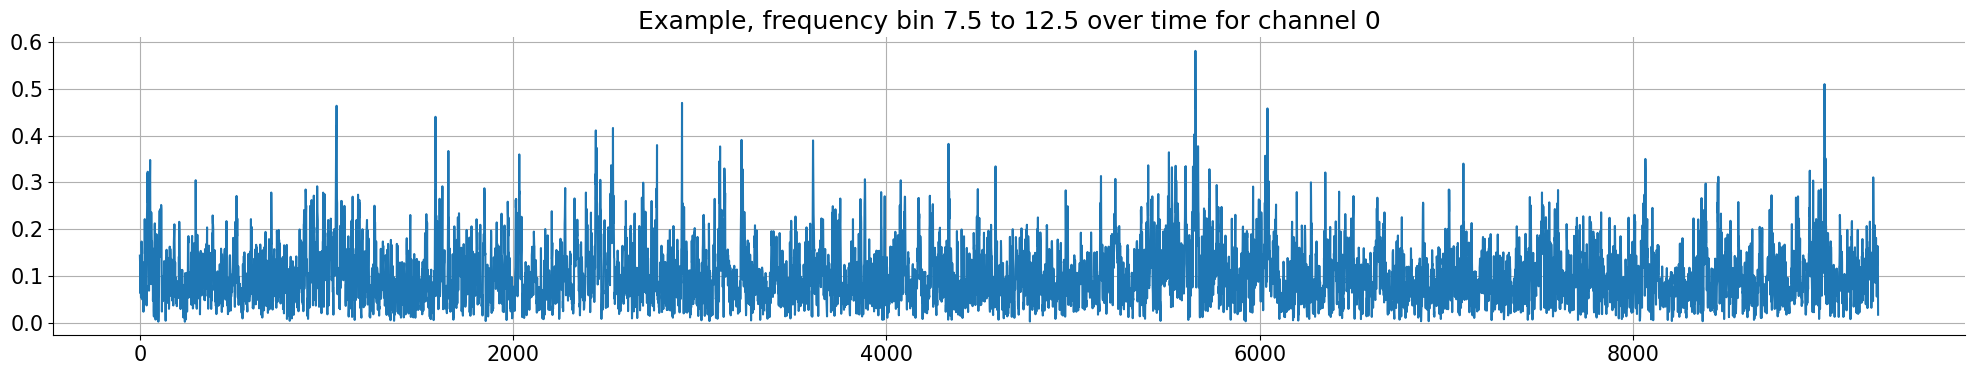

In [68]:
patient = alldat[0][0]
label_to_bin = ['V']
tobin = dict([ (key, patient[key]) for key in label_to_bin])
V_binned = bin_data_to_binsize(tobin, binsize=200, stepsize=40, show_conversion=True)

V_binned = V_binned['V_binned']
V_cm_avg_ref = common_average_reference(V_data=V_binned)

RANGES = ( (8,13),
           (13,30),
           (30,60),
           (60,100),
           (100,200) )

frequency_result, exact_freq_ranges = extract_frequency_features_from_binned_voltage(
    binned_V=V_cm_avg_ref, frequency_ranges=RANGES
    )
print("Activity bins: ")
for res, rng in zip(frequency_result, exact_freq_ranges):
 print("{}:{}".format(res.shape, rng))

FREQUENCY_N, CHANNEL_N = 0, 0
plt.plot(frequency_result[FREQUENCY_N][:,CHANNEL_N])
plt.title(f"Example, frequency bin {'{} to {}'.format(*exact_freq_ranges[FREQUENCY_N])} " +
          f"over time for channel {CHANNEL_N}")
plt.grid()
plt.show()

### Local Motor Potential (LMP)

In [ ]:
# Author: Akira Kudo
# Created: 2024/03/13
# Last updated: 2024/03/14

def extract_lmp_from_binned_voltage(binned_V : np.ndarray):
    """
    Extracts the local motor potential feature from binned
    voltage data. Local motor potential refers to voltage data
    that is amplitude-tuned to cursor movements in the time domain,
    i.e. the voltage value over time correlates closely to the
    cursor movement over the same time period.
    :param np.ndarray binned_V: Binned voltage data,
    [num_bins x binsize x num_channels].
    :returns np.ndarray lmp: LMP of dimension [num_bins x channels].
    """
    # simply compute the voltage average over bins
    lmp = np.mean(binned_V, axis=1)
    return lmp

In [ ]:
patient = alldat[0][0]
label_to_bin = ['V']
tobin = dict([ (key, patient[key]) for key in label_to_bin])
V_binned = bin_data_to_binsize(tobin, binsize=200, stepsize=40, show_conversion=True)

V_binned = V_binned['V_binned']
V_cm_avg_ref = common_average_reference(V_data=V_binned)

lmp = extract_lmp_from_binned_voltage(binned_V=V_cm_avg_ref)

plt.plot(lmp[:, 0])
plt.title("Example LMP from channel 0 over time")
plt.grid()
plt.show()

### Hjorth Activity, Mobility & Complexity


In [ ]:
# Author: Akira Kudo
# Created: 2024/03/20
# Last Updated: 2024/03/21

def extract_Hjorth_features_from_binned_voltage(binned_V : np.ndarray):
    """
    Extracts the Hjorth activity, mobility and complexity features
    from binned voltage data.
    - Hjorth activity: variance
    - Mobility: mean frequency
    - Complexity: changes in frequency over a given time period
    :param np.ndarray binned_V: Binned voltage data,
    [num_bins x binsize x num_channels].
    :returns np.ndarray activity, mobility, complexity: Features, each of
    dimension [num_bins x channels].
    """

    def extract_Hjorth_activity_from_binned_voltage(binned_V : np.ndarray):
      """
      Extracts the Hjorth activity features from binned voltage data.
      Hjorth activity is the variance of signal amplitude per bin.
      :param np.ndarray binned_V: Binned voltage data,
      [num_bins x binsize x num_channels].
      :returns np.ndarray activity: Feature of dim [num_bins x channels].
      """
      # simply return the variance per bins
      activity = np.var(binned_V, axis=1)
      return activity

    def extract_Hjorth_mobility_from_binned_voltage(binned_V : np.ndarray):
      """
      Extracts the Hjorth mobility features from binned voltage data.
      Hjorth mobility is computed as the square root of the ratio of
       1 - the variance of the first derivative of voltage over time
       2 - the variance of voltage amplitude
      :param np.ndarray binned_V: Binned voltage data,
      [num_bins x binsize x num_channels].
      :returns np.ndarray mobility: Feature of dim [num_bins x channels].
      """
      if binned_V.shape[1] < 2:
        raise Exception("Hjorth mobility can be ill-defined when " +
                      "the bin size is smaller than 2...")

      voltage_derivative_over_time = np.diff(binned_V, axis=1)

      V_derivative_variance = np.var(voltage_derivative_over_time, axis=1)
      V_amplitude_variance = np.var(binned_V, axis=1)

      mobility_sq = np.divide(V_derivative_variance, V_amplitude_variance)
      mobility = np.sqrt(mobility_sq)
      return mobility

    def extract_Hjorth_complexity_from_binned_voltage(binned_V : np.ndarray):
      """
      Extracts the Hjorth complexity features from binned voltage data.
      Hjorth complexity is computed as the ratio of:
       1 - Hjorth mobility but computed with variance of the first derivative
           of the amplitude signal vs. the second derivative of the signal
       2 - Hjorth mobility, computed with amplitude below its first derivative
           with respect to time
       :param np.ndarray binned_V: Binned voltage data,
      [num_bins x binsize x num_channels].
      :returns np.ndarray complexity: Feature of dim [num_bins x channels].
      """
      if binned_V.shape[1] < 3:
        raise Exception("Hjorth complexity can be ill-defined when " +
                      "the bin size is smaller than 3...")
      voltage_derivative_over_time = np.diff(binned_V, axis=1)
      voltage_2nd_derivative_over_time = np.diff(voltage_derivative_over_time, axis=1)
      # compute usual mobility first
      V_derivative_variance = np.var(voltage_derivative_over_time, axis=1)
      V_amplitude_variance = np.var(binned_V, axis=1)
      mobility_sq = np.divide(V_derivative_variance, V_amplitude_variance)
      mobility = np.sqrt(mobility_sq)
      # compute first derivative-based mobility next
      V_2nd_derivative_variance = np.var(voltage_2nd_derivative_over_time, axis=1)
      first_derivative_mobility_sq = np.divide(V_2nd_derivative_variance, V_derivative_variance)
      first_derivative_mobility = np.sqrt(first_derivative_mobility_sq)
      # finally compute the ratio
      complexity = np.divide(first_derivative_mobility, mobility)
      return complexity

    activity = extract_Hjorth_activity_from_binned_voltage(binned_V)
    mobility = extract_Hjorth_mobility_from_binned_voltage(binned_V)
    complexity = extract_Hjorth_complexity_from_binned_voltage(binned_V)

    return activity, mobility, complexity

In [ ]:
patient = alldat[0][0]
label_to_bin = ['V']
tobin = dict([ (key, patient[key]) for key in label_to_bin])
V_binned = bin_data_to_binsize(tobin, binsize=200, stepsize=40, show_conversion=True)

V_binned = V_binned['V_binned']
V_cm_avg_ref = common_average_reference(V_data=V_binned)

activity, mobility, complexity = extract_Hjorth_features_from_binned_voltage(binned_V=V_cm_avg_ref)

for feature, feat_name in zip([activity, mobility, complexity],
                              ["activity", "mobility", "complexity"]):
  plt.plot(feature[:, 0])
  plt.title(f"Example {feat_name} from channel 0 over time")
  plt.grid()
  plt.show()